# FIT5202 Assignment 2

## A. Creating Spark Session and Loading the Data

### Step 01: Import Spark Session and initialize Spark

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt

conf = SparkConf().setMaster("local[4]")\
                  .setAppName("FIT5202 Assignment 2")

sc = SparkContext.getOrCreate(conf=conf)

if sc == None:
    print('Hello')
    sc = SparkContext(conf=conf)

spark = SparkSession(sparkContext=sc)

### Step 02: Load the dataset and print the schema and total number of entries

In [3]:
df = spark.read.csv("weatherAUS.csv",
                    header=True,
                    nullValue="NA")
print("The total number of entries of the dataset is {0}.".format(df.count()))

The total number of entries of the dataset is 142193.


In [4]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [5]:
df.show(5, vertical=True)

-RECORD 0-------------------
 Date          | 2008-12-01 
 Location      | Albury     
 MinTemp       | 13.4       
 MaxTemp       | 22.9       
 Rainfall      | 0.6        
 Evaporation   | null       
 Sunshine      | null       
 WindGustDir   | W          
 WindGustSpeed | 44         
 WindDir9am    | W          
 WindDir3pm    | WNW        
 WindSpeed9am  | 20         
 WindSpeed3pm  | 24         
 Humidity9am   | 71         
 Humidity3pm   | 22         
 Pressure9am   | 1007.7     
 Pressure3pm   | 1007.1     
 Cloud9am      | 8          
 Cloud3pm      | null       
 Temp9am       | 16.9       
 Temp3pm       | 21.8       
 RainToday     | No         
 RainTomorrow  | No         
-RECORD 1-------------------
 Date          | 2008-12-02 
 Location      | Albury     
 MinTemp       | 7.4        
 MaxTemp       | 25.1       
 Rainfall      | 0          
 Evaporation   | null       
 Sunshine      | null       
 WindGustDir   | WNW        
 WindGustSpeed | 44         
 WindDir9am   

## B. Data Cleaning and Processing

### Step 03: Delete columns from the dataset

In [6]:
df_dropped = df.drop("Date",
             "Location",
             "Evaporation",
             "Sunshine",
             "Cloud9am",
             "Cloud3pm",
             "Temp9am",
             "Temp3pm")
df_dropped.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



### Step 04: Print the number of missing data in each column

In [7]:
df_dropped.select([count(when(col(c).isNull(), c)).alias(c) for c in df_dropped.columns]).show(vertical=True)

-RECORD 0--------------
 MinTemp       | 637   
 MaxTemp       | 322   
 Rainfall      | 1406  
 WindGustDir   | 9330  
 WindGustSpeed | 9270  
 WindDir9am    | 10013 
 WindDir3pm    | 3778  
 WindSpeed9am  | 1348  
 WindSpeed3pm  | 2630  
 Humidity9am   | 1774  
 Humidity3pm   | 3610  
 Pressure9am   | 14014 
 Pressure3pm   | 13981 
 RainToday     | 1406  
 RainTomorrow  | 0     



In [26]:
null_count = {c: df_dropped.where(df_dropped[c].isNull()).groupBy(c).count().select("count").collect() for c in df_dropped.columns}
null_count

{'MinTemp': [Row(count=637)],
 'MaxTemp': [Row(count=322)],
 'Rainfall': [Row(count=1406)],
 'WindGustDir': [Row(count=9330)],
 'WindGustSpeed': [Row(count=9270)],
 'WindDir9am': [Row(count=10013)],
 'WindDir3pm': [Row(count=3778)],
 'WindSpeed9am': [Row(count=1348)],
 'WindSpeed3pm': [Row(count=2630)],
 'Humidity9am': [Row(count=1774)],
 'Humidity3pm': [Row(count=3610)],
 'Pressure9am': [Row(count=14014)],
 'Pressure3pm': [Row(count=13981)],
 'RainToday': [Row(count=1406)],
 'RainTomorrow': []}

### Step 05: Fill the missing data with average value and maximum occurrence value

In [37]:
# The names of numeric columns
numeric_cols = ["MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"]

# The names of string columns
string_cols  = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]

In [8]:
# Calculate the mean of numeric colums
means = df_dropped.select([mean(col(c)).alias(c) for c in numeric_cols]).collect()[0]

# Form a dictionary where keys are names of columns and values are the means.
ready_to_fill_n = {numeric_cols[i]: means[i] for i in range(len(numeric_cols))}

# Fill the na values for numeric columns.
df_filled_n = df_dropped.na.fill(ready_to_fill_n)

In [9]:
# Define a function to find the mode of string columns
def find_mode(col_name):
    # Find the maximum occurrence of non-null values.
    max = df_dropped.where(df[col_name] != "null")\
                    .groupBy(col_name)\
                    .count()\
                    .groupBy().max("Count").collect()[0][0]
    
    # Group the data again
    grouped = df_dropped.where(df_dropped[col_name] != "null").groupBy(col_name).count()
    
    # Find the value with maximum occurrence.
    mode = grouped.where(grouped["count"] == max).select(col_name).collect()[0][0]
    return mode

# Form a dictionary where keys are names of columns and values are the modes.
ready_to_fill_s = {string_cols[i]: find_mode(string_cols[i]) for i in range(len(string_cols))}

# Fill the na values for string columns.
df_nonull = df_filled_n.na.fill(ready_to_fill_s)

We count the nulls in each column again to see if the transformation really worked.

In [10]:
df_nonull.select([count(when(col(c).isNull(), c)).alias(c) for c in df_nonull.columns]).show(vertical=True)

-RECORD 0------------
 MinTemp       | 0   
 MaxTemp       | 0   
 Rainfall      | 0   
 WindGustDir   | 0   
 WindGustSpeed | 0   
 WindDir9am    | 0   
 WindDir3pm    | 0   
 WindSpeed9am  | 0   
 WindSpeed3pm  | 0   
 Humidity9am   | 0   
 Humidity3pm   | 0   
 Pressure9am   | 0   
 Pressure3pm   | 0   
 RainToday     | 0   
 RainTomorrow  | 0   



### Step 06: Data transformation

In [11]:
# Create the udf for conversion.
converter = udf(lambda x: float(x), DoubleType())

for i in numeric_cols:
    df_nonull = df_nonull.withColumn(i, converter(col(i)))

df_nonull.show(5, truncate=False, vertical=True)

-RECORD 0---------------
 MinTemp       | 13.4   
 MaxTemp       | 22.9   
 Rainfall      | 0.6    
 WindGustDir   | W      
 WindGustSpeed | 44.0   
 WindDir9am    | W      
 WindDir3pm    | WNW    
 WindSpeed9am  | 20.0   
 WindSpeed3pm  | 24.0   
 Humidity9am   | 71.0   
 Humidity3pm   | 22.0   
 Pressure9am   | 1007.7 
 Pressure3pm   | 1007.1 
 RainToday     | No     
 RainTomorrow  | No     
-RECORD 1---------------
 MinTemp       | 7.4    
 MaxTemp       | 25.1   
 Rainfall      | 0.0    
 WindGustDir   | WNW    
 WindGustSpeed | 44.0   
 WindDir9am    | NNW    
 WindDir3pm    | WSW    
 WindSpeed9am  | 4.0    
 WindSpeed3pm  | 22.0   
 Humidity9am   | 44.0   
 Humidity3pm   | 25.0   
 Pressure9am   | 1010.6 
 Pressure3pm   | 1007.8 
 RainToday     | No     
 RainTomorrow  | No     
-RECORD 2---------------
 MinTemp       | 12.9   
 MaxTemp       | 25.7   
 Rainfall      | 0.0    
 WindGustDir   | WSW    
 WindGustSpeed | 46.0   
 WindDir9am    | W      
 WindDir3pm    | WSW    


In [12]:
df_nonull.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = false)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = false)
 |-- WindDir3pm: string (nullable = false)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = false)
 |-- RainTomorrow: string (nullable = true)



In [13]:
# We also should convert the RainTomorrow to index.
string_cols.append("RainTomorrow")

# Chunk the indexers into a list, put the indexed value in to a column
indexers = [StringIndexer(inputCol=i, outputCol=str(i+"indexed")) for i in string_cols]

# Loop through the list to transform the dataframe.
for i in range(len(indexers)):
    df_nonull = indexers[i].fit(df_nonull).transform(df_nonull)

df_nonull.show(10, truncate=False, vertical=True)

-RECORD 0---------------------
 MinTemp             | 13.4   
 MaxTemp             | 22.9   
 Rainfall            | 0.6    
 WindGustDir         | W      
 WindGustSpeed       | 44.0   
 WindDir9am          | W      
 WindDir3pm          | WNW    
 WindSpeed9am        | 20.0   
 WindSpeed3pm        | 24.0   
 Humidity9am         | 71.0   
 Humidity3pm         | 22.0   
 Pressure9am         | 1007.7 
 Pressure3pm         | 1007.1 
 RainToday           | No     
 RainTomorrow        | No     
 WindGustDirindexed  | 0.0    
 WindDir9amindexed   | 6.0    
 WindDir3pmindexed   | 7.0    
 RainTodayindexed    | 0.0    
 RainTomorrowindexed | 0.0    
-RECORD 1---------------------
 MinTemp             | 7.4    
 MaxTemp             | 25.1   
 Rainfall            | 0.0    
 WindGustDir         | WNW    
 WindGustSpeed       | 44.0   
 WindDir9am          | NNW    
 WindDir3pm          | WSW    
 WindSpeed9am        | 4.0    
 WindSpeed3pm        | 22.0   
 Humidity9am         | 44.0   
 Humidit

In [14]:
# Only the first 3 string columns are features
features = numeric_cols + list(map(lambda x: x+"indexed", string_cols[0:3]))

vector_assembler = VectorAssembler(inputCols=features,
                                   outputCol="features")

df_vectorised = vector_assembler.transform(df_nonull)\
                                .withColumnRenamed("RainTomorrowindexed", "label")\
                                .select("RainTomorrow","features", "label")

In [15]:
df_vectorised.show()

+------------+--------------------+-----+
|RainTomorrow|            features|label|
+------------+--------------------+-----+
|          No|[13.4,22.9,0.6,44...|  0.0|
|          No|[7.4,25.1,0.0,44....|  0.0|
|          No|[12.9,25.7,0.0,46...|  0.0|
|          No|[9.2,28.0,0.0,24....|  0.0|
|          No|[17.5,32.3,1.0,41...|  0.0|
|          No|[14.6,29.7,0.2,56...|  0.0|
|          No|[14.3,25.0,0.0,50...|  0.0|
|          No|[7.7,26.7,0.0,35....|  0.0|
|         Yes|[9.7,31.9,0.0,80....|  1.0|
|          No|[13.1,30.1,1.4,28...|  0.0|
|         Yes|[13.4,30.4,0.0,30...|  1.0|
|         Yes|[15.9,21.7,2.2,31...|  1.0|
|         Yes|[15.9,18.6,15.6,6...|  1.0|
|          No|[12.6,21.0,3.6,44...|  0.0|
|          No|[9.8,27.7,2.34997...|  0.0|
|         Yes|[14.1,20.9,0.0,22...|  1.0|
|         Yes|[13.5,22.9,16.8,6...|  1.0|
|          No|[11.2,22.5,10.6,4...|  0.0|
|          No|[9.8,25.6,0.0,26....|  0.0|
|          No|[11.5,29.3,0.0,24...|  0.0|
+------------+--------------------

Now we know that "No" was indexed as 0 and "Yes" was indexed as 1. Hence, we can drop this column now.

In [16]:
df_vectorised = df_vectorised.drop("RainTomorrow")

### Step 07: Create the feature vector and divide the dataset


In [17]:
(trainingData, testData) = df_vectorised.randomSplit([0.7, 0.3], seed = 100)

## C. Apply Machine Learning Algorithms

### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph

In [18]:
# Chunk the classifiers into a dictionary to automate the process
classifiers = {"Decision Tree": DecisionTreeClassifier(labelCol="label", featuresCol="features"),
              "Random Forest": RandomForestClassifier(labelCol="label", featuresCol="features"),
              "Logistic Regression": LogisticRegression(labelCol="label", featuresCol="features"),
              "Gradient Boosted Tree": GBTClassifier(labelCol="label", featuresCol="features")}

# Build models on the classifiers, chunked them into a dictionary
models = {i: classifiers[i].fit(trainingData) for i in classifiers}

# Make predictions using the models
predictions = {i: models[i].transform(testData).select("label", "prediction") for i in classifiers}

# Display the result
for i in predictions:
    print(i)
    predictions[i].show(5, truncate=False)

Decision Tree
+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
+-----+----------+
only showing top 5 rows

Random Forest
+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
+-----+----------+
only showing top 5 rows

Logistic Regression
+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
+-----+----------+
only showing top 5 rows

Gradient Boosted Tree
+-----+----------+
|label|prediction|
+-----+----------+
|1.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
+-----+----------+
only showing top 5 rows



In [19]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="accuracy")

accuracy = {i: evaluator.evaluate(predictions[i]) for i in classifiers}

for i in accuracy:
    print(i)
    print("Test Error = {0} ".format(1.0 - accuracy[i]))
    print("Accuracy = {0}".format(accuracy[i]))
    print()

Decision Tree
Test Error = 0.16408734365062538 
Accuracy = 0.8359126563493746

Random Forest
Test Error = 0.16406378818929168 
Accuracy = 0.8359362118107083

Logistic Regression
Test Error = 0.16269757143193653 
Accuracy = 0.8373024285680635

Gradient Boosted Tree
Test Error = 0.15624337502649988 
Accuracy = 0.8437566249735001



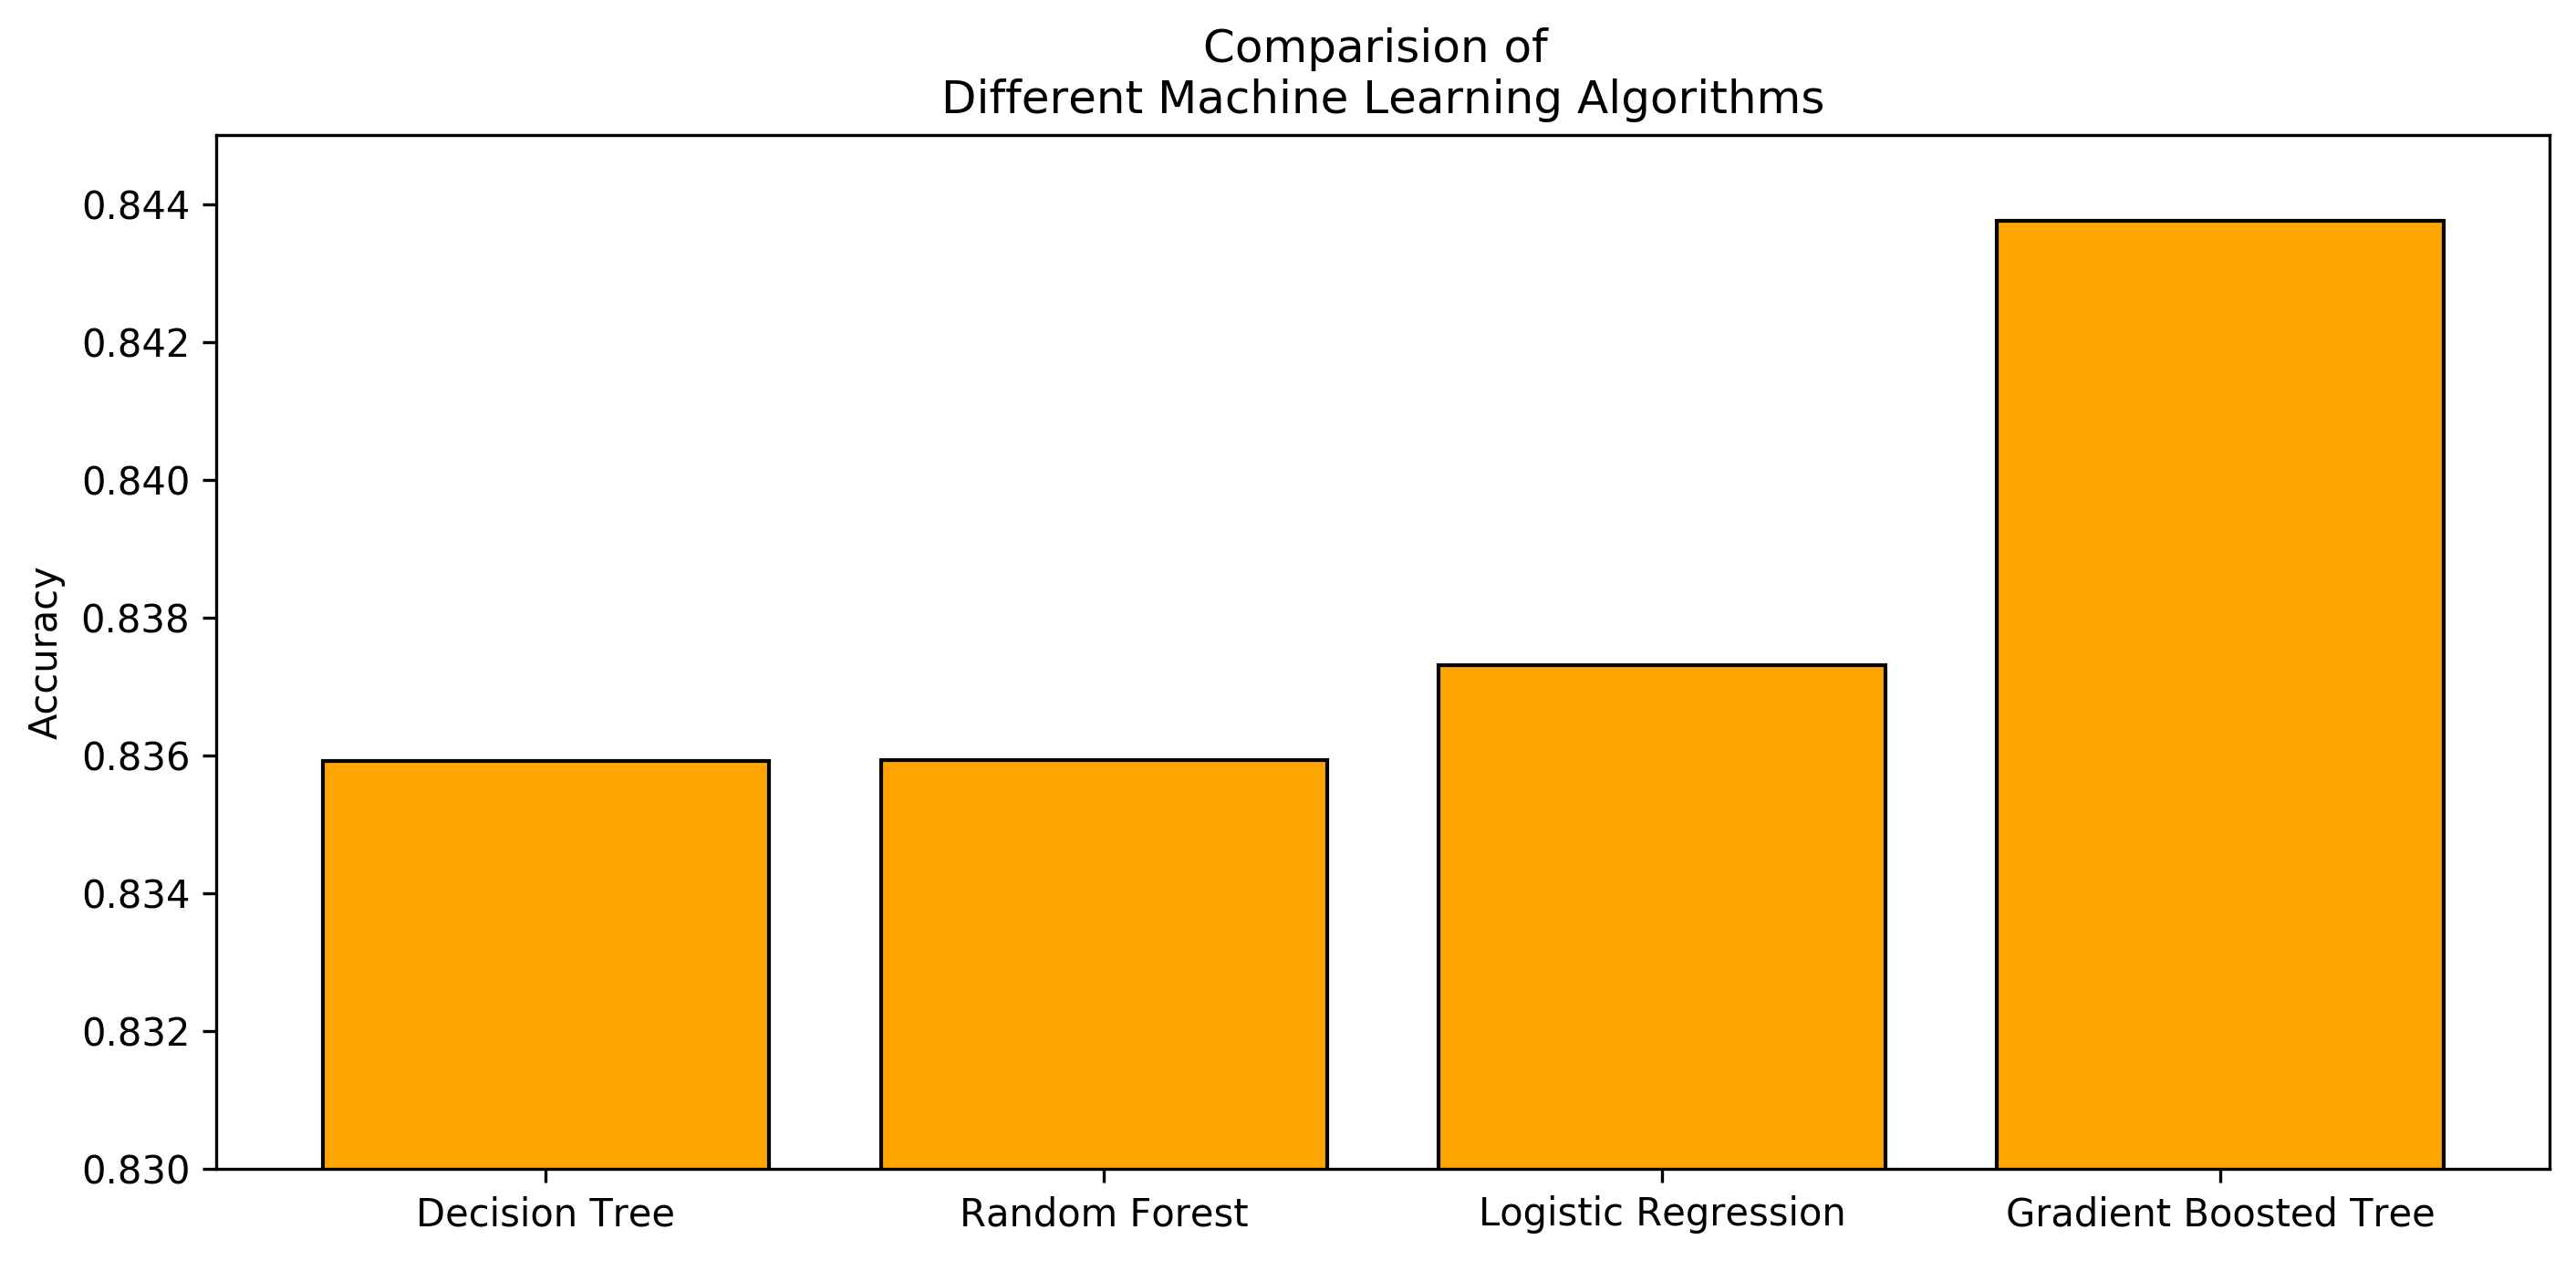

In [20]:
# Iniitialise the canvas
fig, ax = plt.subplots(dpi=300)

# Plot the bar chart
ax.bar(accuracy.keys(), accuracy.values(), edgecolor="black", color="orange")

# Set the limit of y-axis to maximise the difference
ax.set_ylim(bottom=0.830, top=0.845)

# Set the title and axis label
ax.set_title("Comparision of \nDifferent Machine Learning Algorithms")
ax.set_ylabel("Accuracy")

# Set the size of the canvas
fig.set_size_inches(11,5)

plt.show()

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?

#### a. Confusion Matrices

In [21]:
def confusionMatrix(result):
    matrix = {}
    
    # Calculate true positive, false positive, true negative and false negative
    tp = result.where(result["label"] == 1).where(result["prediction"] == 1).count()
    fp = result.where(result["label"] == 0).where(result["prediction"] == 1).count()
    tn = result.where(result["label"] == 0).where(result["prediction"] == 0).count()
    fn = result.where(result["label"] == 1).where(result["prediction"] == 0).count()
    
    # Base on the calculation, calculate these parameters
    matrix["True Positive"] = tp
    matrix["False Positive"] = fp
    matrix["True Negative"] = tn
    matrix["False Negative"] = fn
    matrix["Precision"] = tp/(tp+fp)
    matrix["Recall"] = tp/(tp+fn)
    matrix["F1 score"] = 2*tp/(2*tp + fp + fn)
    
    return matrix

Notice that in this case "positive" refers to "It is going to rain tomorrow" and "negative" otherwise.

In [22]:
confusionMatrices = {i:confusionMatrix(predictions[i]) for i in predictions}

for i in confusionMatrices:
    print(i)
    for j in confusionMatrices[i]:
        print(j+":", confusionMatrices[i][j])
    print()

Decision Tree
True Positive: 3725
False Positive: 1308
True Negative: 31762
False Negative: 5658
Precision: 0.7401152394198292
Recall: 0.39699456463817545
F1 score: 0.5167869034406215

Random Forest
True Positive: 3678
False Positive: 1260
True Negative: 31810
False Negative: 5705
Precision: 0.7448359659781288
Recall: 0.39198550570180113
F1 score: 0.5136512813351023

Logistic Regression
True Positive: 4233
False Positive: 1757
True Negative: 31313
False Negative: 5150
Precision: 0.7066777963272121
Recall: 0.451135031439838
F1 score: 0.5507057828660639

Gradient Boosted Tree
True Positive: 4480
False Positive: 1730
True Negative: 31340
False Negative: 4903
Precision: 0.7214170692431562
Recall: 0.4774592347863157
F1 score: 0.5746168152376067



#### Improving Accuracy

We decided to firstly tune the parameters of the models.

##### Decision Tree

In [42]:
output_1 = ParamGridBuilder().addGrid(classifiers["Decision Tree"].maxDepth,
                                      [5, 6, 7, 8])\
                             .addGrid(classifiers["Decision Tree"].maxBins,
                                      [35, 37, 40])\
                             .build()

cv_1 = CrossValidator(estimator=classifiers["Decision Tree"],
                      estimatorParamMaps=output_1,
                      evaluator=evaluator,
                      numFolds=5,
                      parallelism=4)

cvmodel_1 = cv_1.fit(trainingData)
pred_1 = cvmodel_1.transform(testData)

In [43]:
print('After tuning, the accuracy is: ')
print(evaluator.evaluate(pred_1))
print("---------------------------------")
print('Before tuning, the accuracy is: ')
print(accuracy["Decision Tree"])

After tuning, the accuracy is: 
0.8390455327067581
---------------------------------
Before tuning, the accuracy is: 
0.8354179916613667


In [44]:
print('After tuning, the confusion matrix is: ')
print(confusionMatrix(pred_1))
print("---------------------------------")
print('Before tuning, the confusion matrix is: ')
print(confusionMatrices["Decision Tree"])

After tuning, the confusion matrix is: 
{'True Positive': 4332, 'False Positive': 1782, 'True Negative': 31288, 'False Negative': 5051, 'Precision': 0.7085377821393523, 'Recall': 0.4616860279228392, 'F1 score': 0.5590759501839065}
---------------------------------
Before tuning, the confusion matrix is: 
{'True Positive': 3739, 'False Positive': 1343, 'True Negative': 31727, 'False Negative': 5644, 'Precision': 0.7357339630066903, 'Recall': 0.3984866247468827, 'F1 score': 0.5169720013826478}


It could be observed the accuracy of decision tree increased after tuning. We did sacrifice a little precision, as it could be seen from the confusion matrix; but we had significant increase of recall.

##### Random Forest

In [45]:
output_2 = ParamGridBuilder().addGrid(classifiers["Random Forest"].maxDepth,
                                      [5, 6, 7, 8])\
                             .addGrid(classifiers["Random Forest"].maxBins,
                                      [35, 37, 40])\
                             .addGrid(classifiers["Random Forest"].numTrees,
                                      [20, 25, 30])\
                             .build()

cv_2 = CrossValidator(estimator=classifiers["Random Forest"],
                      estimatorParamMaps=output_2,
                      evaluator=evaluator,
                      numFolds=5,
                      parallelism=4)

cvmodel_2 = cv_2.fit(trainingData)
pred_2 = cvmodel_2.transform(testData)

In [46]:
print('After tuning, the accuracy is: ')
print(evaluator.evaluate(pred_2))
print("---------------------------------")
print('Before tuning, the accuracy is: ')
print(accuracy["Random Forest"])

After tuning, the accuracy is: 
0.842790851058818
---------------------------------
Before tuning, the accuracy is: 
0.8361953218853792


In [48]:
print('After tuning, the confusion matrix is: ')
print(confusionMatrix(pred_2))
print("---------------------------------")
print('Before tuning, the confusion matrix is: ')
print(confusionMatrices["Random Forest"])

After tuning, the confusion matrix is: 
{'True Positive': 4047, 'False Positive': 1338, 'True Negative': 31732, 'False Negative': 5336, 'Precision': 0.7515320334261838, 'Recall': 0.43131194713844184, 'F1 score': 0.5480769230769231}
---------------------------------
Before tuning, the confusion matrix is: 
{'True Positive': 3535, 'False Positive': 1106, 'True Negative': 31964, 'False Negative': 5848, 'Precision': 0.7616892911010558, 'Recall': 0.3767451774485772, 'F1 score': 0.5041357672561323}


The result of tuning random forest is similar to the one of decision tree. We sacrificed a little precision in trade of significant increase of recall, and higher F1 score.

##### Logistic Regression

In [47]:
output_3 = ParamGridBuilder().addGrid(classifiers["Logistic Regression"].threshold,
                                      [0.3, 0.4, 0.5, 0.55])\
                             .build()

cv_3 = CrossValidator(estimator=classifiers["Logistic Regression"],
                      estimatorParamMaps=output_3,
                      evaluator=evaluator,
                      numFolds=5,
                      parallelism=4)

cvmodel_3 = cv_3.fit(trainingData)
pred_3 = cvmodel_3.transform(testData)

In [49]:
print('After tuning, the accuracy is: ')
print(evaluator.evaluate(pred_3))
print("---------------------------------")
print('Before tuning, the accuracy is: ')
print(accuracy["Logistic Regression"])

After tuning, the accuracy is: 
0.8375379831814006
---------------------------------
Before tuning, the accuracy is: 
0.837585094104068


In [50]:
print('After tuning, the confusion matrix is: ')
print(confusionMatrix(pred_3))
print("---------------------------------")
print('Before tuning, the confusion matrix is: ')
print(confusionMatrices["Logistic Regression"])

After tuning, the confusion matrix is: 
{'True Positive': 4162, 'False Positive': 1676, 'True Negative': 31394, 'False Negative': 5221, 'Precision': 0.7129153819801302, 'Recall': 0.4435681551742513, 'F1 score': 0.5468760265422771}
---------------------------------
Before tuning, the confusion matrix is: 
{'True Positive': 4156, 'False Positive': 1668, 'True Negative': 31402, 'False Negative': 5227, 'Precision': 0.7135989010989011, 'Recall': 0.4429287008419482, 'F1 score': 0.5465903860064444}


We noticed that after tuning, the accuracy of the model slightly declined. We considered that randomness was to be blamed. Hence, we think there is not much we could do to improve the accuracy of logistic regression via tuning parameters.

##### Gradient Boosted Tree

In [24]:
output_4 = ParamGridBuilder().addGrid(classifiers["Gradient Boosted Tree"].maxDepth,
                                      [2, 4, 6])\
                             .addGrid(classifiers["Gradient Boosted Tree"].maxBins,
                                      [20, 60])\
                             .addGrid(classifiers["Gradient Boosted Tree"].maxIter,
                                      [20, 25])\
                             .build()

cv_4 = CrossValidator(estimator=classifiers["Gradient Boosted Tree"],
                      estimatorParamMaps=output_4,
                      evaluator=evaluator,
                      numFolds=5,
                      parallelism=4)

cvmodel_4 = cv_4.fit(trainingData)
pred_4 = cvmodel_4.transform(testData)

In [28]:
print('After tuning, the accuracy is: ')
print(evaluator.evaluate(pred_4))
print("---------------------------------")
print('Before tuning, the accuracy is: ')
print(accuracy["Gradient Boosted Tree"])

After tuning, the accuracy is: 
0.8455703954961958
---------------------------------
Before tuning, the accuracy is: 
0.8448401761948507


In [29]:
print('After tuning, the confusion matrix is: ')
print(confusionMatrix(pred_4))
print("---------------------------------")
print('Before tuning, the confusion matrix is: ')
print(confusionMatrices["Gradient Boosted Tree"])

After tuning, the confusion matrix is: 
{'True Positive': 4612, 'False Positive': 1785, 'True Negative': 31285, 'False Negative': 4771, 'Precision': 0.720962951383461, 'Recall': 0.4915272300969839, 'F1 score': 0.5845373891001268}
---------------------------------
Before tuning, the confusion matrix is: 
{'True Positive': 4466, 'False Positive': 1670, 'True Negative': 31400, 'False Negative': 4917, 'Precision': 0.7278357235984355, 'Recall': 0.47596717467760846, 'F1 score': 0.575552548488949}


We can see that by tuning parameter we slightly improved accuracy of the model.

#### Other methods

##### Feature scaling

We observe that for pressure data are very different in scales. It is possible that the scale will effect the precision of the model.

In [23]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
scaleModel = scaler.fit(df_vectorised)
df_scaled = scaleModel.transform(df_vectorised)

In [24]:
(trainingData_s, testData_s) = df_scaled.randomSplit([0.7, 0.3], seed = 100)

In [25]:
# Chunk the classifiers into a dictionary to automate the process
classifiers_n = {"Decision Tree": DecisionTreeClassifier(labelCol="label", featuresCol="scaledFeatures"),
              "Random Forest": RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures"),
              "Logistic Regression": LogisticRegression(labelCol="label", featuresCol="scaledFeatures"),
              "Gradient Boosted Tree": GBTClassifier(labelCol="label", featuresCol="scaledFeatures")}

# Build models on the classifiers, chunked them into a dictionary
models_n = {i: classifiers_n[i].fit(trainingData_s) for i in classifiers_n}

# Make predictions using the models
predictions_n = {i: models_n[i].transform(testData_s).select("label", "prediction") for i in classifiers_n}

In [26]:
accuracy_n = {i: evaluator.evaluate(predictions_n[i]) for i in classifiers_n}

for i in accuracy_n:
    print(i)
    print("Using scaled data:")
    print("Accuracy = {0}".format(accuracy_n[i]))
    print("Using unscaled data:")
    print("Accuracy = {0}".format(accuracy[i]))
    print()

Decision Tree
Using scaled data:
Accuracy = 0.8354415471227004
Using unscaled data:
Accuracy = 0.8352766588933644

Random Forest
Using scaled data:
Accuracy = 0.8353473252773655
Using unscaled data:
Accuracy = 0.8356535462747038

Logistic Regression
Using scaled data:
Accuracy = 0.8380326478694086
Using unscaled data:
Accuracy = 0.8369726521093915

Gradient Boosted Tree
Using scaled data:
Accuracy = 0.8439450686641697
Using unscaled data:
Accuracy = 0.843921513202836



We can hardly see significant differences between using scaled and unscaled data. Hence we consider that scaling the features will not be likely to improve precision.

##### Using more data

In [23]:
(trainingData_m, testData_l) = df_vectorised.randomSplit([0.8, 0.2], seed = 100)

In [24]:
# Chunk the classifiers into a dictionary to automate the process
# "a" after the underline stands for "amount"

classifiers_a = {"Decision Tree": DecisionTreeClassifier(labelCol="label", featuresCol="features"),
              "Random Forest": RandomForestClassifier(labelCol="label", featuresCol="features"),
              "Logistic Regression": LogisticRegression(labelCol="label", featuresCol="features"),
              "Gradient Boosted Tree": GBTClassifier(labelCol="label", featuresCol="features")}

# Build models on the classifiers, chunked them into a dictionary
models_a = {i: classifiers[i].fit(trainingData_m) for i in classifiers_a}

# Make predictions using the models
predictions_a = {i: models_a[i].transform(testData_l).select("label", "prediction") for i in classifiers_a}


In [25]:
accuracy_a = {i: evaluator.evaluate(predictions_a[i]) for i in classifiers_a}

for i in accuracy_a:
    print(i)
    print("More data")
    print("Accuracy = {0}".format(accuracy_a[i]))
    print("Less data")
    print("Accuracy = {0}".format(accuracy[i]))
    print()

Decision Tree
More data
Accuracy = 0.8380895480424545
Less data
Accuracy = 0.8359126563493746

Random Forest
More data
Accuracy = 0.8384058480354256
Less data
Accuracy = 0.8359362118107083

Logistic Regression
More data
Accuracy = 0.8382652702607718
Less data
Accuracy = 0.8373024285680635

Gradient Boosted Tree
More data
Accuracy = 0.8466999367400014
Less data
Accuracy = 0.8437566249735001



##### Using more features

In [26]:
df_dropless = df.drop("Date","Location", "Evaporation", "Sunshine")
df_dropless.printSchema()
df_dropless.show(vertical=True)

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)

-RECORD 0---------------
 MinTemp       | 13.4   
 MaxTemp       | 22.9   
 Rainfall      | 0.6    
 WindGustDir   | W      
 WindGustSpeed | 44     
 WindDir9am    | W      
 WindDir3pm    | WNW    
 

In [27]:
df_dropless.select([count(when(col(c).isNull(), c)).alias(c) for c in df_dropless.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|   53657|   57094|    904|   2726|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+--

In [28]:
numeric_cols_dl = ["MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm"]
string_cols_dl  = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]

means_dl = df_dropless.select([mean(col(c)).alias(c) for c in numeric_cols_dl]).collect()[0]
ready_to_fill_n_dl = {numeric_cols_dl[i]: means_dl[i] for i in range(len(numeric_cols_dl))}
df_filled_dl = df_dropless.na.fill(ready_to_fill_n_dl)

In [29]:
def find_mode(col_name):
    max = df_filled_dl.where(df[col_name] != "null").groupBy(col_name).count().groupBy().max("Count").collect()[0][0]
    grouped = df_filled_dl.where(df[col_name] != "null").groupBy(col_name).count()
    mode = grouped.where(grouped["count"] == max).select(col_name).collect()[0][0]
    return mode

ready_to_fill_s_dl = {string_cols[i]: find_mode(string_cols[i]) for i in range(len(string_cols_dl))}

df_nonull_dl = df_filled_dl.na.fill(ready_to_fill_s_dl)

In [30]:
df_nonull_dl.select([count(when(col(c).isNull(), c)).alias(c) for c in df_nonull_dl.columns]).show(vertical=True)

-RECORD 0------------
 MinTemp       | 0   
 MaxTemp       | 0   
 Rainfall      | 0   
 WindGustDir   | 0   
 WindGustSpeed | 0   
 WindDir9am    | 0   
 WindDir3pm    | 0   
 WindSpeed9am  | 0   
 WindSpeed3pm  | 0   
 Humidity9am   | 0   
 Humidity3pm   | 0   
 Pressure9am   | 0   
 Pressure3pm   | 0   
 Cloud9am      | 0   
 Cloud3pm      | 0   
 Temp9am       | 0   
 Temp3pm       | 0   
 RainToday     | 0   
 RainTomorrow  | 0   



In [31]:
converter = udf(lambda x: float(x), DoubleType())

for i in numeric_cols_dl:
    df_nonull_dl = df_nonull_dl.withColumn(i, converter(col(i)))

df_nonull_dl.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = false)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = false)
 |-- WindDir3pm: string (nullable = false)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- Cloud9am: double (nullable = true)
 |-- Cloud3pm: double (nullable = true)
 |-- Temp9am: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- RainToday: string (nullable = false)
 |-- RainTomorrow: string (nullable = true)



In [32]:
string_cols_dl.append("RainTomorrow")
indexers_dl = [StringIndexer(inputCol=i, outputCol=str(i+"indexed")) for i in string_cols_dl]

for i in range(len(indexers_dl)):
    df_nonull_dl = indexers_dl[i].fit(df_nonull_dl).transform(df_nonull_dl)

df_nonull_dl.show(10, truncate=False, vertical=True)

-RECORD 0--------------------------------
 MinTemp             | 13.4              
 MaxTemp             | 22.9              
 Rainfall            | 0.6               
 WindGustDir         | W                 
 WindGustSpeed       | 44.0              
 WindDir9am          | W                 
 WindDir3pm          | WNW               
 WindSpeed9am        | 20.0              
 WindSpeed3pm        | 24.0              
 Humidity9am         | 71.0              
 Humidity3pm         | 22.0              
 Pressure9am         | 1007.7            
 Pressure3pm         | 1007.1            
 Cloud9am            | 8.0               
 Cloud3pm            | 4.503166899728551 
 Temp9am             | 16.9              
 Temp3pm             | 21.8              
 RainToday           | No                
 RainTomorrow        | No                
 WindGustDirindexed  | 0.0               
 WindDir9amindexed   | 6.0               
 WindDir3pmindexed   | 7.0               
 RainTodayindexed    | 0.0        

In [33]:
features_dl = numeric_cols_dl + list(map(lambda x: x+"indexed", string_cols_dl[0:3]))

vector_assembler = VectorAssembler(inputCols=features_dl,
                                   outputCol="features")

df_vectorised_dl = vector_assembler.transform(df_nonull_dl)\
                                   .withColumnRenamed("RainTomorrowindexed", "label")\
                                   .select("features", "label")

In [34]:
(trainingData_dl, testData_dl) = df_vectorised_dl.randomSplit([0.7, 0.3], seed = 100)

In [35]:
# Build models on the classifiers, chunked them into a dictionary
models_dl = {i: classifiers[i].fit(trainingData_dl) for i in classifiers}

# Make predictions using the models
predictions_dl = {i: models_dl[i].transform(testData_dl).select("label", "prediction") for i in classifiers}

accuracy_dl = {i: evaluator.evaluate(predictions_dl[i]) for i in classifiers}

for i in accuracy:
    print(i)
    print("Using more variables")
    print("Accuracy = {0} ".format(accuracy_dl[i]))
    print("Using less variables")
    print("Accuracy = {0}".format(accuracy[i]))
    print()

Decision Tree
Using more variables
Accuracy = 0.8341931076720137 
Using less variables
Accuracy = 0.8359126563493746

Random Forest
Using more variables
Accuracy = 0.8356299908133701 
Using less variables
Accuracy = 0.8359362118107083

Logistic Regression
Using more variables
Accuracy = 0.773043130049702 
Using less variables
Accuracy = 0.8373024285680635

Gradient Boosted Tree
Using more variables
Accuracy = 0.8432148493628248 
Using less variables
Accuracy = 0.8437566249735001



After the experiment, we can observe that adding more variables even detriments accuracy, particularly in logistic regression.

#### Conclusion on improving precision

Among the four methods we picked in order to improve accuracy, only using more data to do the training and tuning parameters will lead to significant improvement. Adding more variables would even harm accuracy.

Due to the limit of time, we could not try all the methods to improve accuracy. But further effort could be made, such as adding more data in the dataset and eliminating outliers.

Reference:
https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/

## D. Appendix (Please read)

### About type casting 

We did try to convert all the numeric columns to double in Step 01. But we found out that keeping them as strings won't cause the loss of precision. Hence, we decided to keep them as strings and convert them later on. After consulting the tutor, we think that it was the intrinsic dynamic typing of python - therefore pyspark - that did the job.

---

This is the end of Assignment 2.